In [1]:
!pip install flax optax

from absl import app
from absl import flags
from flax import linen as nn
from flax.training import train_state
import jax.numpy as jnp
import jax
from jax import random
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

     |████████████████████████████████| 184 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 41.9 MB/s 
     |████████████████████████████████| 72 kB 366 kB/s 


In [2]:
EPS = 1.e-7
PI = jnp.asarray(jnp.pi)
@jax.jit
def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = jax.nn.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * jnp.log(jax.lax.clamp(EPS, p, 1. - EPS))
    if reduction == 'avg':
        return jnp.mean(log_p, dim)
    elif reduction == 'sum':
        return jnp.sum(log_p, dim)
    else:
        return log_p

@jax.jit
def log_bernoulli(x, p, reduction=None, dim=None):
    pp = jax.lax.clamp(EPS, p, 1. - EPS)
    log_p = x * jnp.log(pp) + (1. - x) * jnp.log(1. - pp)
    if reduction == 'avg':
        return jnp.mean(log_p, dim)
    elif reduction == 'sum':
        return jnp.sum(log_p, dim)
    else:
        return log_p

@jax.jit
def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    log_p = -0.5 * jnp.log(2. * PI) - 0.5 * log_var - 0.5 * jnp.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return jnp.mean(log_p, dim)
    elif reduction == 'sum':
        return jnp.sum(log_p, dim)
    else:
        return log_p

@jax.jit
def log_standard_normal(x, reduction=None, dim=None):
    log_p = -0.5 * jnp.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return jnp.mean(log_p, dim)
    elif reduction == 'sum':
        return jnp.sum(log_p, dim)
    else:
        return log_p

@jax.jit
def reparameterization(mu, log_var, key):
    std = jnp.exp(0.5*log_var)
    eps = jax.random.normal(key, std.shape)
    return mu + std * eps

@jax.jit
def reparameterization_gaussian_diffusion(x, i, key, beta):
    return jnp.sqrt(1. - beta) * x + jnp.sqrt(beta) * jax.random.normal(key, x.shape)

In [3]:
class DDGM(nn.Module):
  p_dnns : list
  decoder_net : nn.Module
  D : int
  T : int
  beta : float
  
  def __call__(self, x, key):
    # Forward Difussion
    zs = [reparameterization_gaussian_diffusion(x, 0, key, self.beta)]
    for i in range(1, self.T):
      zs.append(reparameterization_gaussian_diffusion(zs[-1], i, key, self.beta))
    # Backward Diffusion
    mus = []
    log_vars = []
    for i in range(len(self.p_dnns) - 1, -1, -1):
        h = self.p_dnns[i](zs[i+1])
        mu_i, log_var_i = jnp.split(h, 2, axis=1)
        mus.append(mu_i)
        log_vars.append(log_var_i)
    mu_x = self.decoder_net(zs[0])

    # =====ELBO
    # RE
    RE = log_standard_normal(x - mu_x).sum(-1)
    # KL
    KL = (log_normal_diag(zs[-1], jnp.sqrt(1. - self.beta) * zs[-1], jnp.log(self.beta)) - log_standard_normal(zs[-1])).sum(-1)
    for i in range(len(mus)):
        KL_i = (log_normal_diag(zs[i], jnp.sqrt(1. - self.beta) * zs[i], jnp.log(self.beta)) - log_normal_diag(zs[i], mus[i], log_vars[i])).sum(-1)
        KL = KL + KL_i
    # Final ELBO
    loss = -(RE - KL).mean()
    return loss

  def sample(self, key, batch_size=64):
    z = jax.random.normal(key, [batch_size, self.D])
    for i in range(len(self.p_dnns) - 1, -1, -1):
        h = self.p_dnns[i](z)
        mu_i, log_var_i = jnp.split(h, 2, axis=1)
        z = reparameterization(jnp.tanh(mu_i), log_var_i, key)

    mu_x = self.decoder_net(z)
    return mu_x
  
  def sample_diffusion(self, x, key):
    zs = [reparameterization_gaussian_diffusion(x, 0, key, self.beta)]
    for i in range(1, self.T):
        zs.append(reparameterization_gaussian_diffusion(zs[-1], i, key, self.beta))
    return zs[-1]


    

In [4]:
D = 64   # input dimension

M = 256  # the number of neurons in scale (s) and translation (t) nets

T = 5

beta = 0.6
batch_size = 64
lr = 1e-3 # learning rate
num_epochs = 500 # max. number of epochs
max_patience = 50 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

class PNN(nn.Module):
  """A simple  model."""
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(M)(x)
    x = nn.leaky_relu(x)
    x = nn.Conv(32, kernel_size=(4,))(x)
    x = nn.leaky_relu(x)
    x = nn.Dense(M)(x)
    x = nn.leaky_relu(x)
    x = nn.Dense(M)(x)
    x = nn.leaky_relu(x)
    x = nn.Dense(2*D)(x)
    return x

class DecoderNN(nn.Module):
  """A simple  model."""
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(2*M)(x)
    x = nn.leaky_relu(x)
    x = nn.Conv(32, kernel_size=(4,))(x)
    x = nn.leaky_relu(x)
    x = nn.Dense(2*M)(x)
    x = nn.leaky_relu(x)
    x = nn.Dense(2*M)(x)
    x = nn.leaky_relu(x)
    x = nn.Dense(D)(x)
    x = nn.tanh(x)
    return x
p_dnns = [PNN() for _ in range(T-1)]

decoder_net = DecoderNN()

def model():
  return DDGM(p_dnns, decoder_net, beta=beta, T=T, D=D)

@jax.jit
def train_step(state, batch, z_rng):
  def loss_fn(params):
    loss = model().apply({'params': params}, batch, z_rng)
    return loss
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)


def eval(params, loader, z_rng):
  def eval_model(model):
    for _, image in enumerate(loader):
      image = jnp.reshape(image, (-1, D))
      loss = 0
      N = 0
      loss_t = model(image, z_rng)
      loss = loss + loss_t
      N = N + image.shape[0]
      loss = loss / N
      return loss
  
  return nn.apply(eval_model, model())({'params': params})

In [5]:
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample


def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))
transforms = lambda x: 2. * (x / 17.) - 1.

train_data = Digits(mode='train', transforms=transforms)
val_data = Digits(mode='val', transforms=transforms)
test_data = Digits(mode='test', transforms=transforms)


training_generator = NumpyLoader(train_data, batch_size=batch_size, num_workers=0)
test_generator = NumpyLoader(test_data, batch_size=batch_size, num_workers=0)

In [6]:
init_data = jnp.ones((batch_size, D), jnp.float32)
key = jax.random.PRNGKey(0)
rng = random.PRNGKey(0)
rng, key = random.split(rng)
state = train_state.TrainState.create(
    apply_fn=model().apply,
    params=model().init(key, init_data, rng)['params'],
    tx=optax.adam(lr),
)

In [7]:
for epoch in range(num_epochs):
  print(f"Epoch: {epoch}")
  for label, image in enumerate(training_generator):
    image = jnp.reshape(image, (-1, D))
    rng, key = random.split(rng)
    state = train_step(state, image, key)
  loss = eval(state.params, test_generator, key)
  print(loss)


Epoch: 0
6.0146794
Epoch: 1
5.8738303
Epoch: 2
5.8846083
Epoch: 3
5.8119984
Epoch: 4
5.8917007
Epoch: 5
5.8215
Epoch: 6
5.8675838
Epoch: 7
5.636202
Epoch: 8
5.737648
Epoch: 9
5.8093123
Epoch: 10
5.7807264
Epoch: 11
5.7757864
Epoch: 12
5.742663
Epoch: 13
5.691368
Epoch: 14
5.7408767
Epoch: 15
5.637843
Epoch: 16
5.6899834
Epoch: 17
5.673231
Epoch: 18
5.65938
Epoch: 19
5.6173463
Epoch: 20
5.6934776
Epoch: 21
5.56594
Epoch: 22
5.66125
Epoch: 23
5.5863523
Epoch: 24
5.5563602
Epoch: 25
5.58949
Epoch: 26
5.485114
Epoch: 27
5.5487485
Epoch: 28
5.510537
Epoch: 29
5.572013
Epoch: 30
5.519507
Epoch: 31
5.5105486
Epoch: 32
5.378225
Epoch: 33
5.4592457
Epoch: 34
5.295246
Epoch: 35
5.360175
Epoch: 36
5.261623
Epoch: 37
5.271876
Epoch: 38
5.2681646
Epoch: 39
5.2631254
Epoch: 40
5.2225866
Epoch: 41
5.116143
Epoch: 42
5.1805534
Epoch: 43
5.177808
Epoch: 44
5.184434
Epoch: 45
5.2305546
Epoch: 46
5.195857
Epoch: 47
5.1463165
Epoch: 48
5.1293306
Epoch: 49
5.0692916
Epoch: 50
5.08785
Epoch: 51
5.037245
Epo

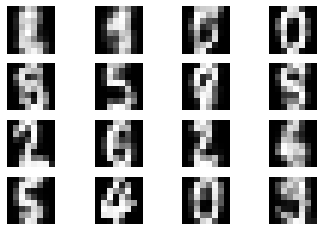

In [8]:
def generate(params, images, z_rng):
  def eval_model(model):
    num_x = 4
    num_y = 4
    x = model.sample(z_rng, batch_size=num_x * num_y)
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
  return nn.apply(eval_model, model())({'params': params})

generate(state.params, test_generator, rng)